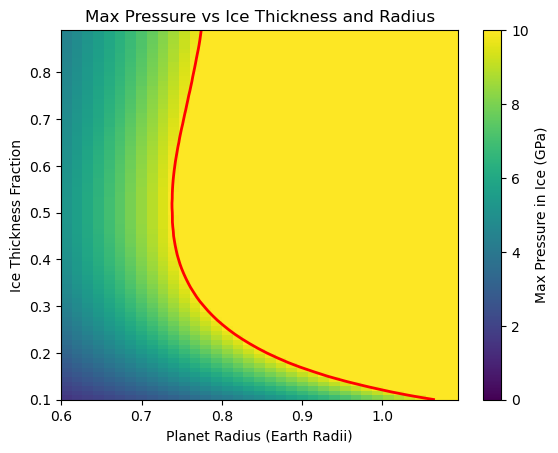

In [14]:
# This cell is for replotting straight from the csv
# Run the next cell if there is no existing csv
# 'twilight' colormap option may be best. Adjust vmin,vmax to 0,20 to center at 10 GPa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('max_pressure_data.csv')

ice_thicknesses = np.sort(df['ice_thickness_fraction'].unique())
earth_radii = np.sort(df['planet_radius_Earth_units'].unique())

z_matrix = df.pivot(index='ice_thickness_fraction', columns='planet_radius_Earth_units', values='max_pressure_GPa').values

plt.figure()
extent = [earth_radii[0], earth_radii[-1], ice_thicknesses[0], ice_thicknesses[-1]]

vmin, vmax = 0, 20
img = plt.imshow(z_matrix, origin='lower',aspect='auto',extent=extent, cmap='viridis', interpolation='none', vmin=vmin, vmax=vmax)

plt.colorbar(img, label='Max Pressure in Ice (GPa)')

X, Y = np.meshgrid(earth_radii, ice_thicknesses)
contour = plt.contour(X, Y, z_matrix, levels=[10], colors='red', linewidths=2)

plt.xlabel('Planet Radius (Earth Radii)')
plt.ylabel('Ice Thickness Fraction')
plt.title('Max Pressure vs Ice Thickness and Radius')

plt.savefig("contour_colormap_from_csv_1.png", bbox_inches='tight')
plt.show()

Calculating max pressure: 100%|███████████████████████████████| 2960/2960 [7:47:34<00:00,  9.48s/it]


Saved pressure data to 'max_pressure_data.csv'


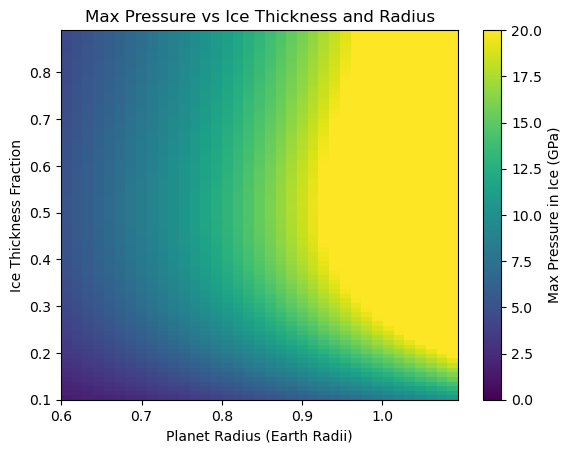

In [5]:
import planetary_dictionary as pd
from looped_solver import Solver 
import matplotlib.pyplot as plt
import numpy as np
import tqdm

r_earth = 6370 * (10 ** 3)

def plot_max_p_vs_ratio(up_to_rad):
    ice_thicknesses = np.arange(0.1, 0.9, 0.01)
    earth_radii = np.arange(0.6, up_to_rad, up_to_rad / 80)

    z_matrix = np.zeros((len(ice_thicknesses), len(earth_radii)))

    total_iterations = len(ice_thicknesses) * len(earth_radii)
    progress = tqdm.tqdm(total=total_iterations, desc="Calculating max pressure", ncols=100)
    
    for i, ice_thick in enumerate(ice_thicknesses):
        for j, earth_rad in enumerate(earth_radii):
            x = (1 - ice_thick) / 2
            fe = x
            si = x

            iceball_profile_dictionary = pd.planetary_dictionary(earth_rad, fe, si)
            radius = earth_rad * r_earth
            iceball_radii_list = [*range(1, int(radius), int(radius / 1000))]

            pressures = Solver(iceball_radii_list, iceball_profile_dictionary)[1]
            pressures_in_ice = [
                p for k, p in enumerate(pressures)
                if iceball_radii_list[k] >= list(iceball_profile_dictionary.keys())[1]
            ]

            max_p = max(pressures_in_ice)
            z_matrix[i, j] = max_p
            
            progress.update(1)

    progress.close()

    with open('max_pressure_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ice_thickness_fraction', 'planet_radius_Earth_units', 'max_pressure_GPa'])

        for i, ice_thick in enumerate(ice_thicknesses):
            for j, earth_rad in enumerate(earth_radii):
                writer.writerow([ice_thick, earth_rad, z_matrix[i, j] / 1e9])
    
    print("Saved pressure data to 'max_pressure_data.csv'")
    
    plt.figure()
    extent = [earth_radii[0], earth_radii[-1], ice_thicknesses[0], ice_thicknesses[-1]]

    z_matrix_gpa = z_matrix / 1e9

    vmin, vmax = 0, 20 
    img = plt.imshow(
        z_matrix_gpa,
        origin='lower',
        aspect='auto',
        extent=extent,
        cmap='viridis',
        interpolation='none',
        vmin=vmin,
        vmax=vmax
    )

    plt.colorbar(img, label='Max Pressure in Ice (GPa)')

    X, Y = np.meshgrid(earth_radii, ice_thicknesses)

    contour_level = 10
    contour = plt.contour(X, Y, z_matrix, levels=[contour_level], colors='red', linewidths=2)
    
    plt.xlabel('Planet Radius (Earth Radii)')
    plt.ylabel('Ice Thickness Fraction')
    plt.title('Max Pressure vs Ice Thickness and Radius')
    
    plt.savefig("contour_colormap.png", bbox_inches='tight')
    plt.show()

plot_max_p_vs_ratio(1.1)
